In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import heapq
from skimage.draw import line
import random

# **RRT Guided**

In [139]:
class Node:
    def __init__(self, x, y, theta, g=0, h=0, f=0, parent=None):
        self.x = x
        self.y = y
        self.theta = theta % 360
        self.g = g
        self.h = h
        self.f = f
        self.parent = parent
    def __eq__(self, other):
        return (self.x == other.x and self.y == other.y and self.theta == other.theta)

    def __lt__(self, other):
        return self.f < other.f

    def key(self, angular_resolution):
        return f"{self.x}_{self.y}_{int(self.theta / angular_resolution)}"

In [152]:
class A_Star:
    def __init__(self, start, goal, cspace_maps, map_resolution=0.5, angular_resolution=5, vertices=None, edges=None):
        self.start = start
        self.goal = goal
        self.cspace_maps = cspace_maps
        self.map_resolution = map_resolution
        self.angular_resolution = angular_resolution
        self.open_list = []
        self.closed_set = set()
        self.map_size = cspace_maps[0].shape
        self.path = []
        self.total_steps = 0
        self.vertices = vertices
        self.edges = edges

    def init_open_list(self):
        start_node = Node(self.start[0], self.start[1], self.start[2])
        start_node.h = self.get_heuristic(start_node)
        start_node.f = start_node.g + start_node.h
        heapq.heappush(self.open_list, (start_node.f, start_node))

    def is_goal(self,node):
        return node.x == self.goal[0] and node.y == self.goal[1]


    def movement_cost(self, node, neighbor):
        # Translation Cost
        if node.x != neighbor.x or node.y != neighbor.y:
            rr,cc = line(node.x, node.y, neighbor.x, neighbor.y)
            return (len(rr) - 1)
        # Rotation Cost (Not Applied)
        else:
            angle_diff = min(abs(node.theta - neighbor.theta), 360 - abs(node.theta - neighbor.theta))
            steps = angle_diff / angular_resolution
            return steps

    def get_heuristic(self, node):
        '''
        Apply Euclidean distance to a node and goal.
        Args:
            node: input node

        Returns: heuristic value
        '''
        # Position Diff, Euclidean Distance
        pos_diff = np.sqrt((node.x - self.goal[0]) ** 2 + (node.y - self.goal[1]) ** 2)
        # Angle Diff
        angle_diff = min(abs(node.theta - self.goal[2]), 360 - abs(node.theta - self.goal[2])) / self.angular_resolution
        return pos_diff + angle_diff

    def reconstruct_path(self,node):
        path = []
        total_steps = node.g
        while node:
            path.append((node.x, node.y, node.theta))
            node = node.parent
        path.reverse()
        return path, total_steps

    def gen_neighbors(self, node):
        neighbors = []
        # Find Neighbors
        node_ind = self.vertices.index((node.x, node.y, node.theta))
        for edge in self.edges:
            if node_ind in edge:
                neighbor_ind = edge[0] if edge[1] == node_ind else edge[1]
                neighbor = self.vertices[neighbor_ind]
                neighbors.append(Node(neighbor[0], neighbor[1], neighbor[2]))
        return neighbors

    def run(self):
        # Open List is not empty
        while self.open_list:
            current_node = heapq.heappop(self.open_list)[1]
            # Check Goal
            if self.is_goal(current_node):
                self.path, self.total_steps = self.reconstruct_path(current_node)
                return
            # Add current node to closed set
            key = current_node.key(self.angular_resolution)
            self.closed_set.add(key)

            # Get Neighbor
            neighbors = self.gen_neighbors(current_node)
            for neighbor in neighbors:
                # Check if neighbor in closed list
                key = neighbor.key(self.angular_resolution)
                if key in self.closed_set:
                    continue

                # Compute g for neighbor
                tentative_g = current_node.g + self.movement_cost(current_node, neighbor)

                # Update if neighbor in open list
                in_open_list = False
                for item in self.open_list:
                    if neighbor == item[1]:
                        in_open_list = True
                        if tentative_g < neighbor.g:
                            neighbor.g = tentative_g
                            neighbor.f = neighbor.g + neighbor.h
                            neighbor.parent = current_node
                        break
                # Add if neighbor not in open list
                if not in_open_list:
                    neighbor.g = tentative_g
                    neighbor.h = self.get_heuristic(neighbor)
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.parent = current_node
                    heapq.heappush(self.open_list, (neighbor.f, neighbor))
        return

In [227]:
class Guided_RRT():
    def __init__(self, start, goal, num_sample, cspace_map,angles, angular_resolution = 5, intermediate_goals = None):
        self.start = start
        self.goal = goal
        self.num_sample = num_sample
        self.cspace = cspace_map
        self.angles = angles
        self.angular_resolution = angular_resolution
        self.vertices = []
        self.edges = set()
        self.intermediate_goals = intermediate_goals if intermediate_goals else [goal]

    def find_nearest_vertex(self, node):
        nodes_array = np.array(self.vertices)
        if len(nodes_array) == 0:
            return
        nodes_array_2d = nodes_array[:, :2]
        node_2d = node[:2]
        distances = np.linalg.norm(nodes_array_2d - node_2d, axis=1)
        neighbor_ind = np.argmin(distances)
        neighbor = self.vertices[neighbor_ind]
        return neighbor

    def check_collision_node(self, node):
        node_x = node[0]
        node_y = node[1]
        node_theta = node[2]
        if self.cspace[node_theta][node_x][node_y] != 0:
            return True
        return False

    def check_collision_edge(self, q_1, q_2):
        # Check rotation
        angle_diff = (int(q_1[2]) - int(q_2[2]) + 360) % 360
        steps_to_rotate = angle_diff / self.angular_resolution
        if steps_to_rotate != 0:
            rotation_direction = self.angular_resolution if angle_diff <= 180 else -self.angular_resolution
            temp_theta = int(q_1[2])
            while temp_theta != int(q_2[2]):
                temp_theta = (temp_theta + rotation_direction + 360) % 360
                # Rotation from q_1 to q_2 is blocked
                if self.check_collision_node((q_1[0], q_1[1], temp_theta)):
                    return True

        # Check connection
        rr,cc = line(q_1[0], q_1[1], q_2[0], q_2[1])
        for row, col in zip(rr,cc):
            if self.check_collision_node((row, col, q_2[2])):
                return True
        return False

    def find_new_config(self,q_1, q_2):
        # Check rotation
        angle_diff = (int(q_1[2]) - int(q_2[2]) + 360) % 360
        steps_to_rotate = angle_diff / self.angular_resolution
        if steps_to_rotate != 0:
            rotation_direction = self.angular_resolution if angle_diff <= 180 else -self.angular_resolution
            temp_theta = int(q_1[2])
            while temp_theta != int(q_2[2]):
                temp_theta = (temp_theta + rotation_direction + 360) % 360
                # Rotation from q_1 to q_2 is blocked
                if self.check_collision_node((q_1[0], q_1[1], temp_theta)):
                    return None

        # Find new config with the longest distance
        rr,cc = line(q_1[0], q_1[1], q_2[0], q_2[1])
        new_config = None
        for row, col in zip(rr,cc):
            if self.check_collision_node((row, col, q_2[2])):
                break
            new_config = (row, col, q_2[2])
        return new_config

    def connect_to_skeleton(self, pos):
        nodes_array = np.array(self.vertices)
        if len(nodes_array) == 0:
            return
        nodes_array_2d = nodes_array[:, :2]
        pos_2d = pos[:2]
        distances = np.linalg.norm(nodes_array_2d - pos_2d, axis=1)
        nearest_idx = np.argmin(distances)
        nearest_skel_point = tuple(nodes_array[nearest_idx])
        if self.check_collision_edge(pos, nearest_skel_point):
            return
        self.vertices.append(pos)
        pos_ind = self.vertices.index(pos)
        self.edges.add((pos_ind, nearest_idx))
        return

    def add_goal(self):
        self.connect_to_skeleton(self.goal)

    def swap_xy(self):
        vertices = [(y, x, theta) for x, y, theta in self.vertices]
        return vertices, self.edges

    def distance_to_goal(self, node, goal):
        return np.sqrt((node[0] - goal[0]) ** 2 + (node[1] - goal[1]) ** 2)

    def add_remain(self):
        cspace_cpy = self.cspace.copy()
        while len(self.vertices) < self.num_sample:
            # Random sample angle
            angle = random.choice(self.angles)
            sample_space = cspace_cpy[angle]
            # Sample in free space
            free_space_indices = np.argwhere(sample_space == 0)
            free_ind = np.random.choice(len(free_space_indices))
            node = tuple(free_space_indices[free_ind])
            node = (node[0], node[1], angle)
            if any(v[0] == node[0] and v[1] == node[1] for v in self.vertices):
                continue

            # Find Neighbor (Nearest)
            neighbor = self.find_nearest_vertex(node)
            # Can Connect
            if not self.check_collision_edge(neighbor, node):
                self.vertices.append(node)
                node_ind = self.vertices.index(node)
                neighbor_ind = self.vertices.index(neighbor)
                self.edges.add((neighbor_ind, node_ind))
                continue


    def run(self):
        # Add start to graph
        self.vertices.append(self.start)
        cspace_cpy = self.cspace.copy()

        for intermediate_goal in self.intermediate_goals:
            count = 0
            while count <= 14:
                node = None
                if random.random() < 0.5:  # 30% 的概率偏向当前中间目标
                    angle = random.choice(self.angles)
                    node = (intermediate_goal[0], intermediate_goal[1], angle)
                else:
                    # Random sample angle
                    angle = random.choice(self.angles)
                    sample_space = cspace_cpy[angle]
                    # Sample in free space
                    free_space_indices = np.argwhere(sample_space == 0)
                    free_ind = np.random.choice(len(free_space_indices))
                    node = tuple(free_space_indices[free_ind])
                    node = (node[0], node[1], angle)
                if any(v[0] == node[0] and v[1] == node[1] for v in self.vertices):
                    continue

                # Find Neighbor (Nearest)
                neighbor = self.find_nearest_vertex(node)
                # Can Connect
                if not self.check_collision_edge(neighbor, node):
                    self.vertices.append(node)
                    node_ind = self.vertices.index(node)
                    neighbor_ind = self.vertices.index(neighbor)
                    self.edges.add((neighbor_ind, node_ind))
                    count += 1

                '''if self.distance_to_goal(node, intermediate_goal) < 5:  # 距离小于阈值，认为到达
                    break'''


        self.add_goal()
        return self.swap_xy()


In [186]:
map_resolution = 0.5
angular_resolution = 5
num_ori = 360 / angular_resolution
data = loadmat('cspaceMaps_python.mat')
angles = data['angles'][0]
map = data['mapMatrix']
cspace = {}
for index, angle in enumerate(angles):
    space = data['cspace'][0][index]
    cspace[angle] = space

# **RRT Guided Sample:50**

In [211]:
start = (25, 25, 90)
goal = (25, 375, 0)
num_sample = 50
intermediate_goals = [
    (125,25,0),
    (125,175,0),
    (25, 175, 0),
    (25, 225, 0),
    (125,225, 0),
    (125,375,0),
    (25,375,0),
]
rrt = Guided_RRT(start, goal, num_sample, cspace, angles, angular_resolution, intermediate_goals)
vertices,edges = rrt.run()

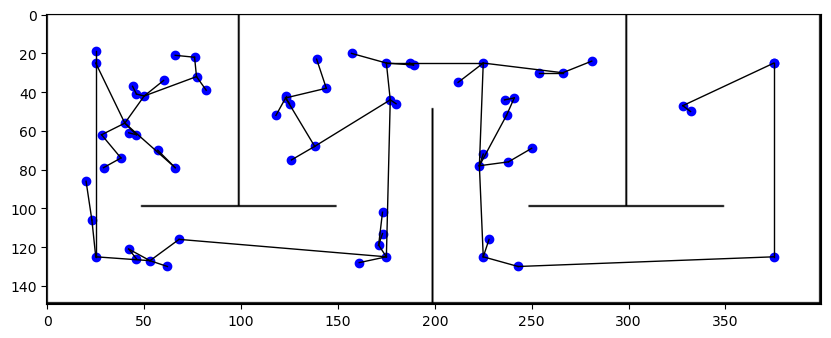

In [213]:
map_display = 1 - map
x_coords = [v[0] for v in vertices]
y_coords = [v[1] for v in vertices]

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c='blue', label='Vertices')
for edge in edges:
    start, end = edge
    x = [vertices[start][0], vertices[end][0]]
    y = [vertices[start][1], vertices[end][1]]
    plt.plot(x, y, c='black', linestyle='-', linewidth=1)
plt.imshow(map_display, cmap='gray', origin='upper')
plt.savefig('RRT_sample_50_guided.png')
plt.show()

In [214]:
start = (25, 25, 90)
goal = (375,25, 0)
map_resolution = 0.5
angular_resolution = 5

planner = A_Star(start, goal, cspace, map_resolution, angular_resolution, vertices, edges)
planner.init_open_list()
planner.run()

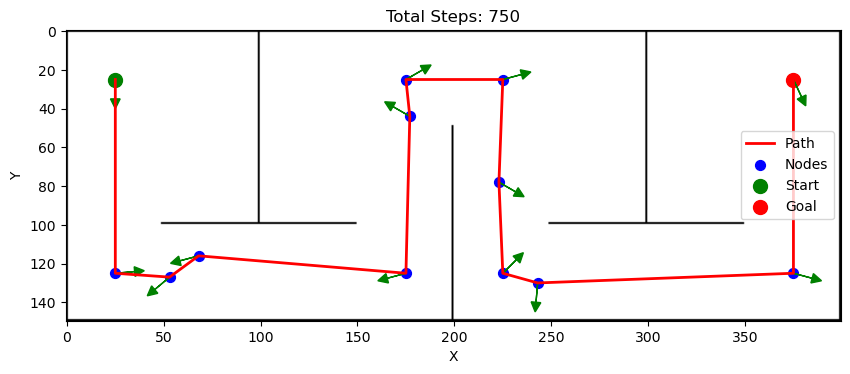

In [215]:
path = planner.path
path_x = [p[0] for p in path]
path_y = [p[1] for p in path]
path_theta = [p[2] for p in path]

plt.figure(figsize=(10, 8))
plt.imshow(map_display, cmap='gray', origin='upper')
plt.plot(path_x, path_y, 'r-', linewidth=2, label='Path')
plt.scatter(path_x, path_y, c='blue', s=50, label='Nodes')
plt.scatter(path_x[0], path_y[0], c='green', s=100, label='Start', marker='o')
plt.scatter(path_x[-1], path_y[-1], c='red', s=100, label='Goal', marker='o')
for x, y, theta in path:
    dx = np.cos(np.radians(theta)) * 10
    dy = np.sin(np.radians(theta)) * 10
    plt.arrow(x, y, dx, dy, head_width=5, head_length=5, fc='green', ec='green')

plt.title(f'Total Steps: {planner.total_steps}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig('RRT_50_path.png')
plt.show()

## **RRT Guided Sample:100**

In [266]:
start = (25, 25, 90)
goal = (25, 375, 0)
num_sample = 100
intermediate_goals = [
    (125,25,0),
    (125,175,0),
    (25, 175, 0),
    (25, 225, 0),
    (125,225, 0),
    (125,375,0),
    (25,375,0),
]
rrt = Guided_RRT(start, goal, num_sample, cspace, angles, angular_resolution, intermediate_goals)
vertices,edges = rrt.run()

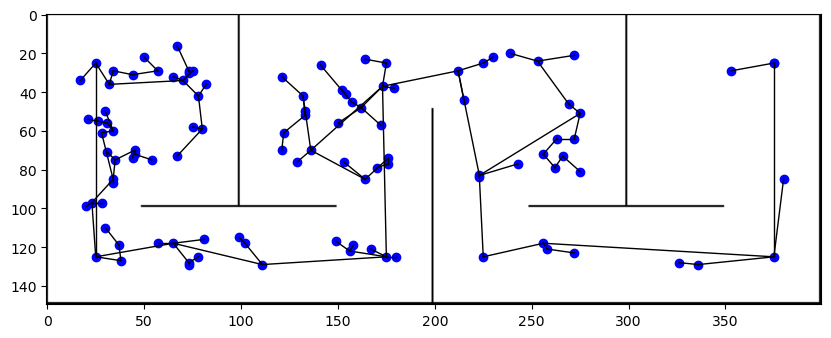

In [270]:
map_display = 1 - map
x_coords = [v[0] for v in vertices]
y_coords = [v[1] for v in vertices]

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c='blue', label='Vertices')
for edge in edges:
    start, end = edge
    x = [vertices[start][0], vertices[end][0]]
    y = [vertices[start][1], vertices[end][1]]
    plt.plot(x, y, c='black', linestyle='-', linewidth=1)
plt.imshow(map_display, cmap='gray', origin='upper')
plt.savefig('RRT_sample_100_guided.png')
plt.show()

In [268]:
start = (25, 25, 90)
goal = (375,25, 0)
map_resolution = 0.5
angular_resolution = 5

planner = A_Star(start, goal, cspace, map_resolution, angular_resolution, vertices, edges)
planner.init_open_list()
planner.run()

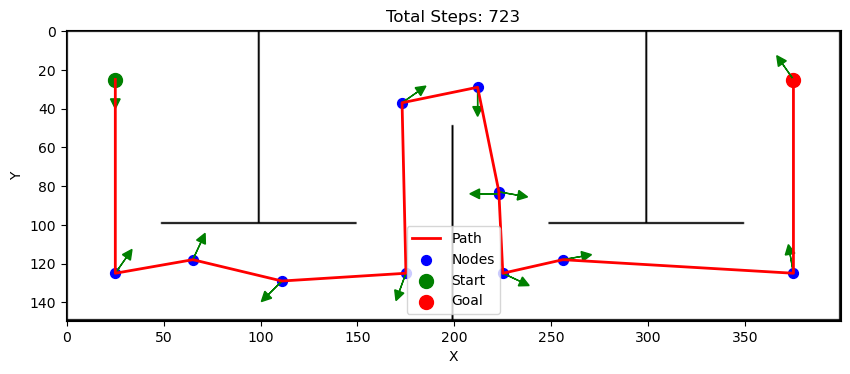

In [271]:
path = planner.path
path_x = [p[0] for p in path]
path_y = [p[1] for p in path]
path_theta = [p[2] for p in path]

plt.figure(figsize=(10, 8))
plt.imshow(map_display, cmap='gray', origin='upper')
plt.plot(path_x, path_y, 'r-', linewidth=2, label='Path')
plt.scatter(path_x, path_y, c='blue', s=50, label='Nodes')
plt.scatter(path_x[0], path_y[0], c='green', s=100, label='Start', marker='o')
plt.scatter(path_x[-1], path_y[-1], c='red', s=100, label='Goal', marker='o')
for x, y, theta in path:
    dx = np.cos(np.radians(theta)) * 10
    dy = np.sin(np.radians(theta)) * 10
    plt.arrow(x, y, dx, dy, head_width=5, head_length=5, fc='green', ec='green')

plt.title(f'Total Steps: {planner.total_steps}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('RRT_100_path.png')
plt.show()